# mnist-explanation

In this notebook, I try to implement explanation methods as described by G. Montavon et al. in their paper `Methods for Interpreting and Understanding Deep Neural Networks` [1]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision

In [2]:
mean, std = (0.1307, 0.3081)
transforms = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((mean,), (std,))
                             ])

In [3]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

In [4]:
testset  = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
testloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=False, num_workers=2)

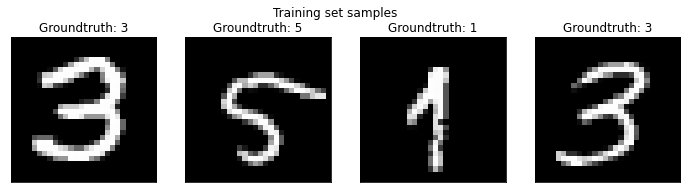

In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

fig, ax = plt.subplots(1,4)
fig.suptitle('Training set samples')
fig.set_size_inches(12,3)
for i in range(images.shape[0]):
    ax[i].imshow(images[i][0], cmap='gray')
    ax[i].set_title('Groundtruth: {}'.format(labels[i].item()))
    ax[i].set_xticks([])
    ax[i].set_yticks([])

## Neural Network Implementation

In their original paper, the researchers do not explicit the structure of the Deep Neural Network (DNN) used in the scope of their study.

## References

[1] Grégoire Montavon, Wojciech Samek, Klaus-Robert Müller, Methods for interpreting and understanding deep neural networks, Digital Signal Processing, Volume 73, 2018, Pages 1-15, ISSN 1051-2004, https://doi.org/10.1016/j.dsp.2017.10.011. (https://www.sciencedirect.com/science/article/pii/S1051200417302385)